In [1]:
import numpy as np
import pandas as pd
from scipy.stats import norm, mannwhitneyu
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
from scipy import stats
%matplotlib inline

In [2]:
data = pd.read_csv('https://stepik.org/media/attachments/lesson/396008/hw_bootstrap.csv', sep=';')

In [3]:
data.head()

,Unnamed: 0,value,experimentVariant
0,1,"10,3804953740268",Control
1,2,"9,54686666784264",Control
2,3,"11,0882146509904",Control
3,4,"10,1472740570122",Control
4,5,"9,78980767524929",Control


In [4]:
data.experimentVariant.value_counts()

Control      500
Treatment    500
Name: experimentVariant, dtype: int64

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 3 columns):
Unnamed: 0           1000 non-null int64
value                1000 non-null object
experimentVariant    1000 non-null object
dtypes: int64(1), object(2)
memory usage: 23.6+ KB


### Шаг 1 
 Подготовка данных для анализа 

In [6]:
data['value'] = data.value.apply(lambda c: c.replace(',', '.'))

In [7]:
data['value'] = data.value.astype('float')

### Шаг 2
Проверка распределений 2ух выборок (контрольной и тестовой групп) на нормальность с помощью теста Шапиро-Уилка для дальнейших выводвов.

H0 - выборка распределена нормально

H1 - распределение отличается от нормального

In [8]:
#Проверка распределения выборок на нормальность
a = stats.shapiro(data.query('experimentVariant == "Control"').value)
b = stats.shapiro(data.query('experimentVariant == "Treatment"').value)

print("Результат тест Шапиро-Уилка для распрделения контрольной группы: {}".format(a))
print("Результат тест Шапиро-Уилка для распрделения тестовой группы   : {}".format(b))

Результат тест Шапиро-Уилка для распрделения контрольной группы: (0.9959248900413513, 0.22416365146636963)
Результат тест Шапиро-Уилка для распрделения тестовой группы   : (0.07038933038711548, 1.0930128021733573e-43)


### Вывод
Тест Шапиро показал не значимый результат для контрольной группы (p-value > 0.05), следовательно не отвергается гипотеза о нормальном распределении данной выборки.
Для тестовой группы p-value значимо (< 0.05), гипотеза о нормальности распределения отвергается.

### Шаг 3
Сравнение средних двух выборок (control и treatment) двумя способами: метод Bootstrap и критерий Mann-Whitney

In [9]:
#применим метод Bootstrap
# h0 - mean(a) = mean(b)
# h1 - maen(a) != mean(b)

In [10]:
# Объявим функцию, которая позволит проверять гипотезы с помощью бутстрапа
def get_bootstrap(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            boot_len, 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            boot_len, 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1 - samples_2)) # mean() - применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    ci = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    plt.hist(pd_boot_data[0], bins = 50)
    
    plt.style.use('ggplot')
    plt.vlines(ci,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "ci": ci, 
            "p_value": p_value}

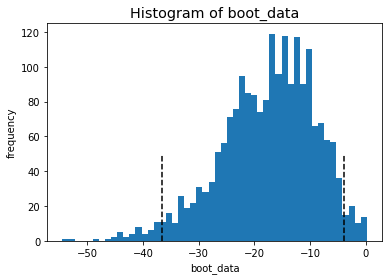

In [11]:
booted_data = get_bootstrap(data.query('experimentVariant == "Control"').value, data.query('experimentVariant == "Treatment"').value, boot_it = 2000) # в результате хранится разница двух распределений, ДИ и pvalue

In [12]:
booted_data["p_value"] 

0.03832577110601602

P-value полученное методом Bootstrap значимо (p < 0.05) => отклоняем нулевую гипотезу о равенстве средних

In [13]:
booted_data["ci"]

,0
0.025,-36.555279
0.975,-3.956336


Применяем критерий Mann-Whitney к выборкам:

H0 - различия между группами не значимы

H1 - различия между группами значимы

In [14]:
u, p_value = stats.mannwhitneyu(data.query('experimentVariant == "Control"').value, data.query('experimentVariant == "Treatment"').value)
print("Two-sample mannwhitneyu-test", p_value)

Two-sample mannwhitneyu-test 0.42960742912427896


Критерий Mann-Whitney дает не значимое p-value (> 0.05) => нет оснований отклонить нулевую гипотезу

### Вывод:
p-value (Bootstrap) < p-value (Mann-Whitney)

В данном случае, результаты полученные для p-value с помощью метода Bootstrap и критерия Mann-Whitney показали разные значения, при которых в первом случае возможно отклонение нулевой гипотезы о равенстве средних, а во втором случае различия между группами оказались не значимы.  

### Шаг 4
Сравнение медиан двух выборок (control и treatment) двумя способами: метод Bootstrap и критерий Mann-Whitney

In [15]:
#применим метод Bootstrap
# h0 - median(a) = median(b)
# h1 - madien(a) != median(b)

In [16]:
# Объявим функцию, которая позволит проверять гипотезы с помощью бутстрапа
def get_bootstrap(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.median, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            boot_len, 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            boot_len, 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1 - samples_2)) # mean() - применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    ci = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.median(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.median(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    plt.hist(pd_boot_data[0], bins = 50)
    
    plt.style.use('ggplot')
    plt.vlines(ci,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "ci": ci, 
            "p_value": p_value}

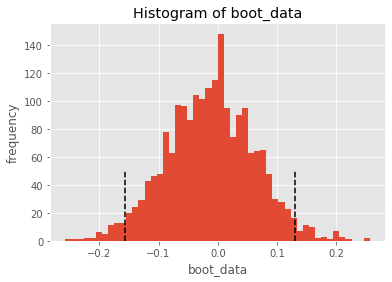

In [17]:
booted_data = get_bootstrap(data.query('experimentVariant == "Control"').value, data.query('experimentVariant == "Treatment"').value, boot_it = 2000) # в результате хранится разница двух распределений, ДИ и pvalue

In [18]:
booted_data["p_value"] 

0.8866211925722813

In [19]:
booted_data["ci"]

,0
0.025,-0.156172
0.975,0.130724


В данном случае, при рассчете медианы с помощью метода Bootstrap, p-value не значим т.к. > 0.05, также 0 входит в доверительный интервал, исходя из чего нет оснований отвергнуть нулевую гипотезу о равенстве медиан.

p-value (Bootstrap) > p-value (Mann-Witney)

### Общий вывод 
Тест Shapiro на нормальность распределния показал значимый результат для тестовой группы, что говорит о том, что распределние для данной выборки отлично от нормального.
В данном случае проводить тест на равенство средних не состоятельно, поскольку для данных, распределенных не нормально лучшей оценкой центральной тенденции является медиана.
Так и проведенные тесты показали, что при проверке равенства медиан двух групп методом Bootstrap, значение получанное для p-value не дает оснований отвергнуть нулевую гипотезу о равенстве медиан, 
как и критерий Mann-Whitney оценил p-value > 0.05, что в свою очередь не позволяет отвергнуть гипотезу о наличии различий между группами.